In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os
#sys.path.append('/Users/ff/dev/MSc/CX_Path_Integration')
#os.chdir('/Users/ff/dev/MSc/CX_Path_Integration/notebooks')

In [54]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt

import cx_rate
import trials
import plotter

import cx_spiking.plotting 
import cx_spiking.inputs
import cx_spiking.optimisation.metric as metric
import cx_spiking.network_creation as nc

from cx_spiking.constants import *

In [56]:
# Constants
#N_TL2 = 16
#N_CL1 = 16
#N_TB1 = 8
#N_TN2 = 2

In [58]:
route_file = 'data/route.npz'
T_outbound = 1500

h, v, = cx_spiking.inputs.generate_route(T_outbound=T_outbound, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=True)

# Convert headings
headings = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)

# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)

Load route from data/route.npz
data/route.npz exists - not overwriting it


In [59]:
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, cx_log, cpu4_snapshot = trials.run_trial(logging=True,
                                            T_outbound=T_outbound,
                                            T_inbound=0,
                                            noise=noise,
                                            cx=cx,
                                            route=(h[:T_outbound], v[:T_outbound]))

TB1_neuron_params {'EL': [-52. * mvolt], 'Vm': [-52. * mvolt], 'EE': [0. * volt], 'EI': [-80. * mvolt], 'gL': [1. * usiemens], 'gE': '(randn() * 1.5 + 4) * 10.*nS', 'gI': '(randn() * 12 + 20) * 10.*nS', 'tauE': [0.5 * msecond], 'tauI': [0.5 * msecond]}
CL1_TB1_synapses_params {'wE': [300. * nsiemens], 'wI': [200. * nsiemens]}
TB1_TB1_synapses_params {'wE': [200. * nsiemens], 'wI': [300. * nsiemens]}
{'EL': [-52. * mvolt], 'Vm': [-52. * mvolt], 'EE': [0. * volt], 'EI': [-80. * mvolt], 'gL': [1. * usiemens], 'gE': '(randn() * 1.5 + 4) * 10.*nS', 'gI': '(randn() * 12 + 20) * 10.*nS', 'tauE': 0.5 * msecond, 'tauI': 100. * usecond}
{'wE': 0.55 * usiemens, 'wI': 0.55 * usiemens}
{'wE': 0.55 * usiemens, 'wI': 0.55 * usiemens}


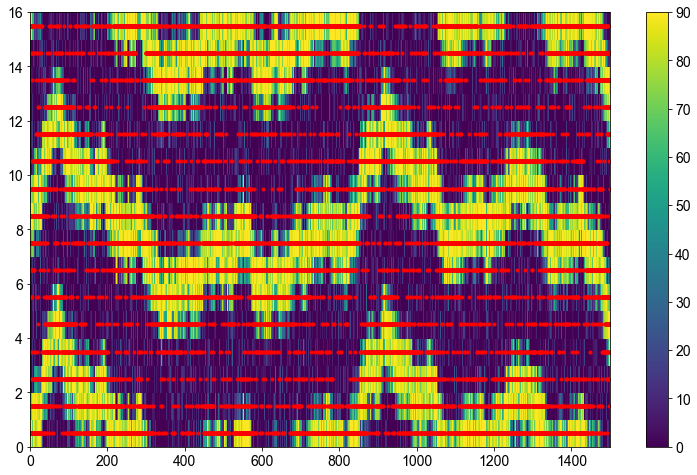

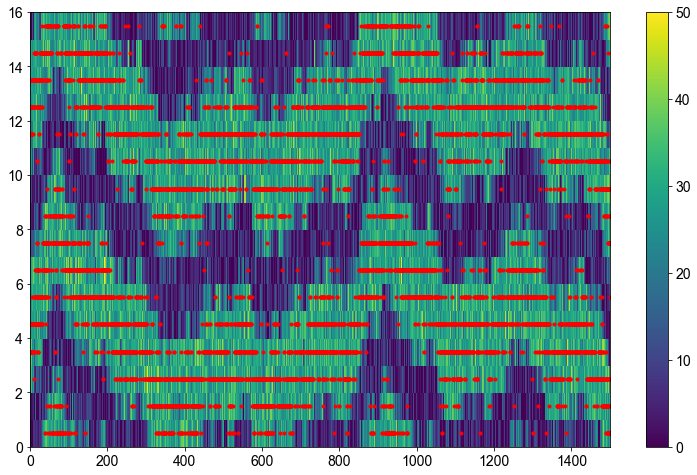

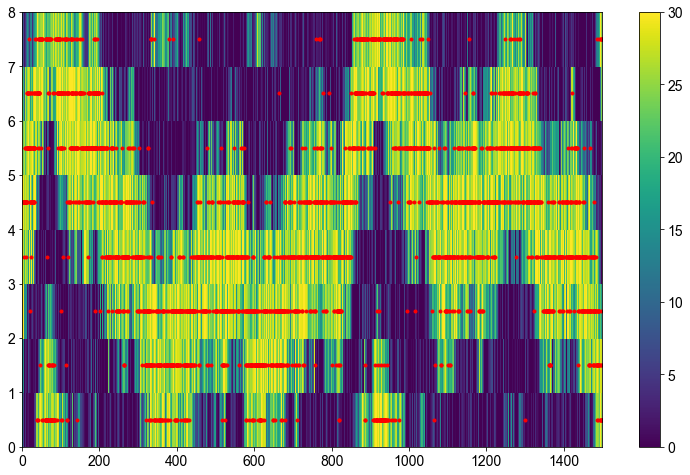

In [76]:
start_scope()

time_step = 20 # ms

# params_CL1['tauI'] = 1 * ms
# synapses_CL1['wI'] = 300 * nS

print(f'TB1_neuron_params {TB1_neuron_params}')
print(f'CL1_TB1_synapses_params {CL1_TB1_synapses_params}')
print(f'TB1_TB1_synapses_params {TB1_TB1_synapses_params}')


h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)')



TB1_neuron_params_ = neuron_params
TB1_neuron_params_['tauE'] = 0.5 *ms
TB1_neuron_params_['tauI'] = 0.1 *ms

CL1_TB1_synapses_params_ = synapses_params
CL1_TB1_synapses_params_['wE'] = 550 *nS

TB1_TB1_synapses_params_ = synapses_params
TB1_TB1_synapses_params_['wI'] = 550 *nS

print(TB1_neuron_params_)
print(CL1_TB1_synapses_params_)
print(TB1_TB1_synapses_params_)

# Neuron group
G_TL2 = nc.generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, TL2_neuron_params, name='TL2_test')
G_CL1 = nc.generate_neuron_groups(N_CL1, eqs, threshold_eqs, reset_eqs, CL1_neuron_params, name='CL1_test')
G_TB1 = nc.generate_neuron_groups(N_TB1, eqs, threshold_eqs, reset_eqs, TB1_neuron_params_, name='TB1_test')

# Add monitors
STM_TL2, SPM_TL2 = nc.add_monitors(G_TL2, name='TL2_test')
STM_CL1, SPM_CL1 = nc.add_monitors(G_CL1, name='CL1_test')
STM_TB1, SPM_TB1 = nc.add_monitors(G_TB1, name='TB1_test')


# Connect heading to TL2
S_P_HEADING_TL2 = nc.connect_synapses(P_HEADING, G_TL2, W_HEADING_TL2, model=synapses_model, 
                                      params=H_TL2_synapses_params, on_pre=synapses_eqs_ex)
S_TL2_CL1 = nc.connect_synapses(G_TL2, G_CL1, W_TL2_CL1, model=synapses_model, 
                                params=TL2_CL1_synapses_params, on_pre=synapses_eqs_ex)                            
S_CL1_TB1 = nc.connect_synapses(G_CL1, G_TB1, W_CL1_TB1, model=synapses_model, 
                                params=CL1_TB1_synapses_params_, on_pre=synapses_eqs_ex)
S_TB1_TB1 = nc.connect_synapses(G_TB1, G_TB1, W_TB1_TB1, model=synapses_model, 
                                params=TB1_TB1_synapses_params_, on_pre=synapses_eqs_in)


# Run simulation
run(T_outbound*time_step*ms)

cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.tl2, TL2_spike_rates, SPM_TL2, 
                                            time_step, figsize=(13,8), savefig_='plots/TL2_grid_search.pdf')
cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cl1, CL1_spike_rates, SPM_CL1, 
                                            time_step, figsize=(13,8), savefig_=f'plots/CL1_grid_search.pdf')
cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.tb1, TB1_spike_rates, SPM_TB1, 
                                            time_step, figsize=(13,8), savefig_=f'plots/TB1_grid_search.pdf')
#cx_spiking.plotting.plot_gamma_factors(gamma_factors, tauI_s_full, wI_s_full, 
#                                       title='TB1', xlabel='wI (nS)', ylabel='tauI (ms)', 
#                                       figsize=(11,7), savefig_='plots/TB1_gamma_factors_grid_search.pdf')


In [62]:
start_scope()

time_step = 20 # ms


TB1_stimulus = TimedArray(TB1_spike_rates*cx_log.tb1.T*Hz, dt=1.*time_step*ms)
P_TB1 = PoissonGroup(N_CL1, rates='TB1_stimulus(t,i)')
SPM_P_TB1 = SpikeMonitor(P_TB1, name='TB1_target')

run(T_outbound*time_step*ms)



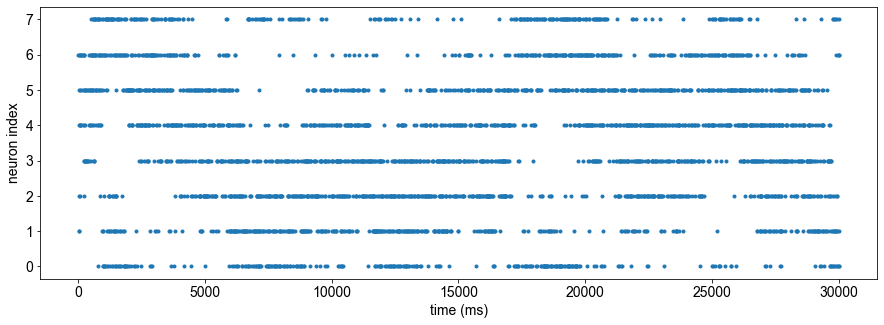

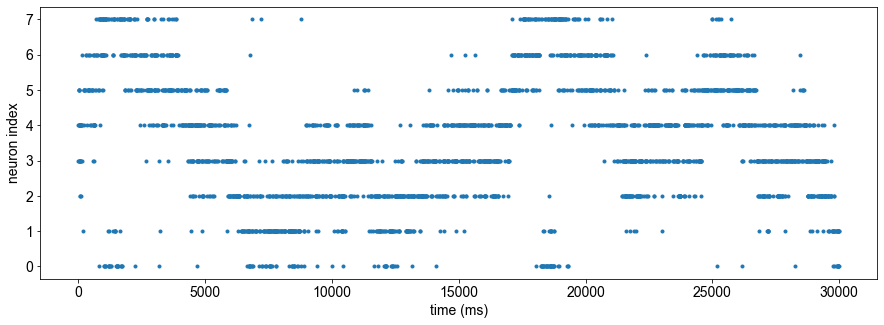

In [71]:
plt.figure(figsize=(15,5))
brian_plot(SPM_P_TB1)
plt.show()

plt.figure(figsize=(15,5))
brian_plot(SPM_TB1)
plt.show()



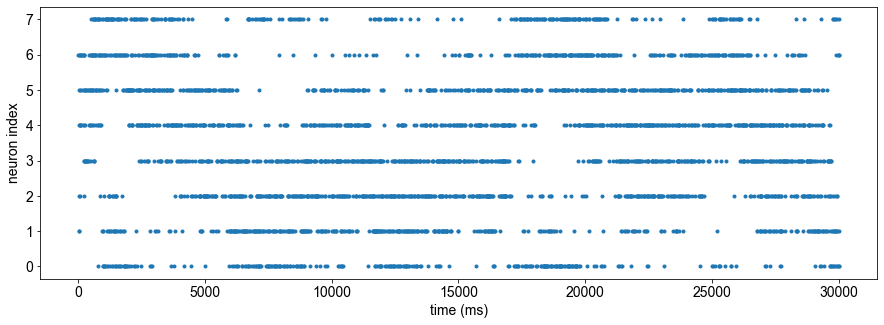

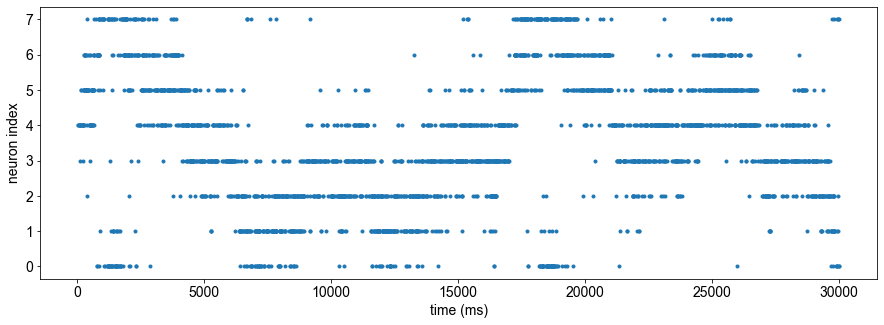

1.3133026042483047


In [80]:
plt.figure(figsize=(15,5))
brian_plot(SPM_P_TB1)
plt.show()


plt.figure(figsize=(15,5))
brian_plot(SPM_TB1)
plt.show()
gf = metric.compute_gamma_factor(SPM_TB1, SPM_P_TB1, T_outbound*time_step*ms, 
                                 dt_=defaultclock.dt, delta=1*ms, rate_correction=True)
print(gf)


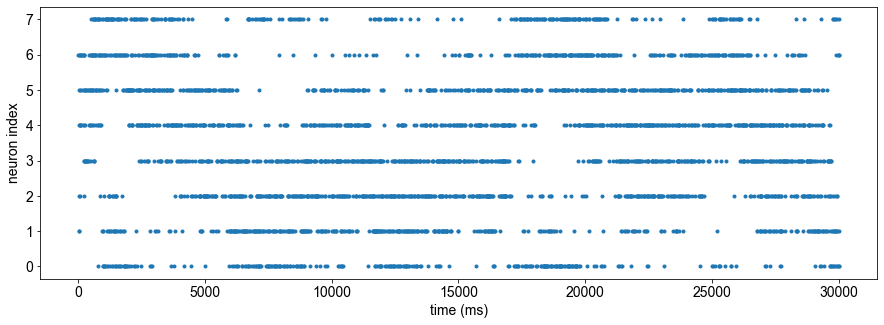

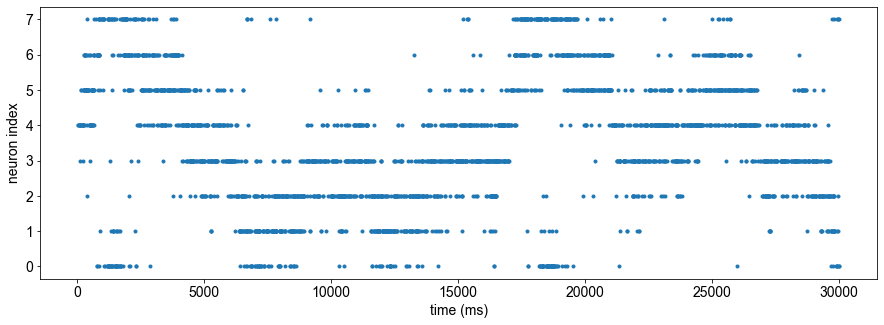

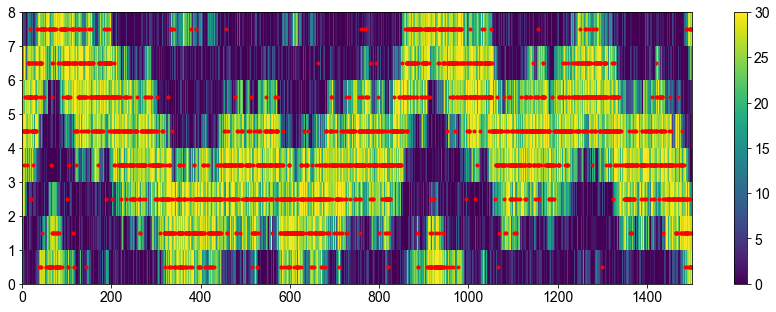

1.3133026042483047


In [81]:
plt.figure(figsize=(15,5))
brian_plot(SPM_P_TB1)
plt.show()


plt.figure(figsize=(15,5))
brian_plot(SPM_TB1)
plt.show()

cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.tb1, TB1_spike_rates, SPM_TB1, 
                                            time_step, figsize=(15,5))


gf = metric.compute_gamma_factor(SPM_TB1, SPM_P_TB1, T_outbound*time_step*ms, 
                                 dt_=defaultclock.dt, delta=1*ms, rate_correction=True)
print(gf)



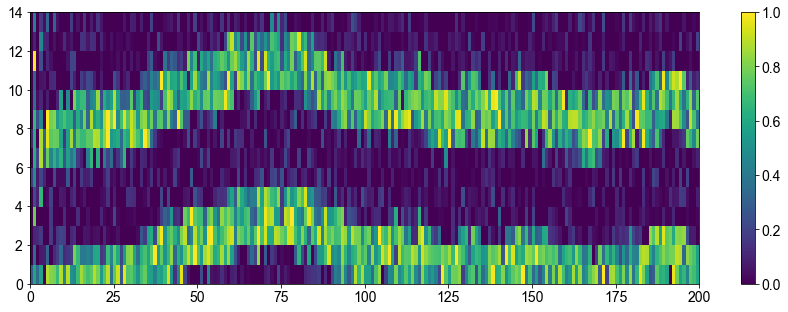

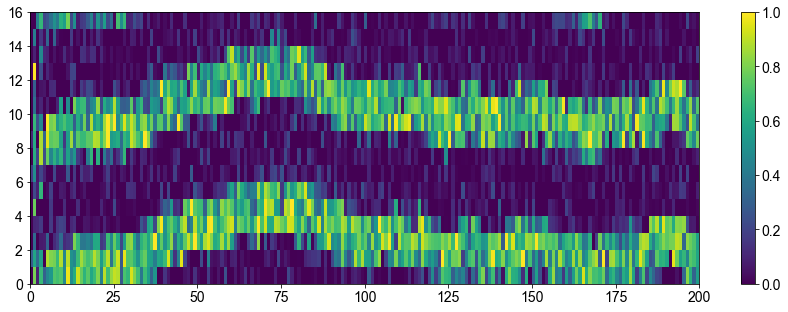

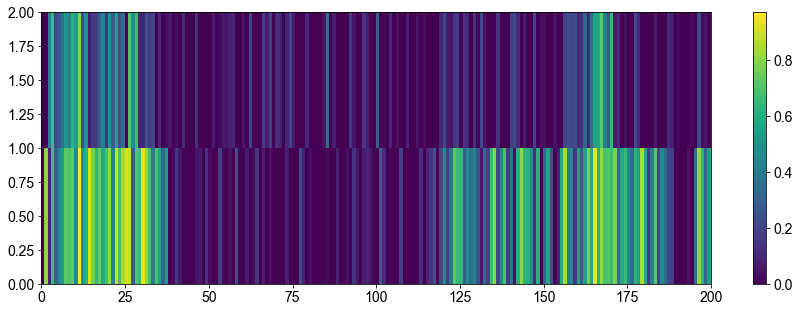

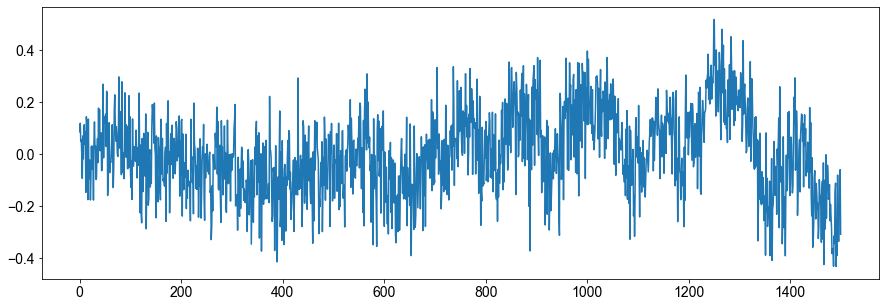

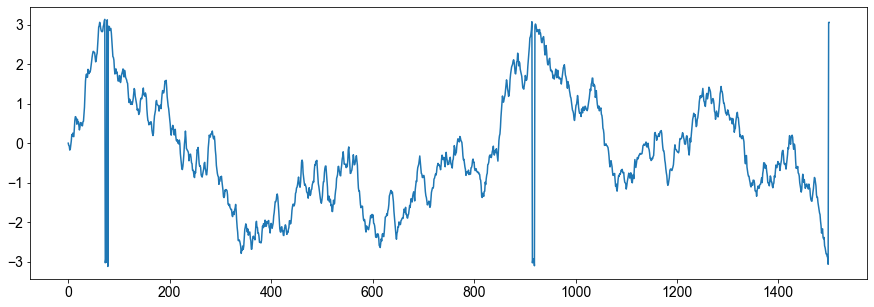

(1500, 14)
(1500,)


In [109]:
#plt.imshow(cx_log.tb1[:,:50])
#plt.colorbar()
#plt.show()

#plt.imshow(cx_log.cpu4[:,:50])
#plt.colorbar()
#plt.show()

plt.figure(figsize=(15,5))
plt.pcolormesh(cx_log.cpu1[1:-1,:200])
plt.colorbar()
plt.show()
plt.figure(figsize=(15,5))
plt.pcolormesh(cx_log.cpu1[:,:200])
plt.colorbar()
plt.show()
plt.figure(figsize=(15,5))
plt.pcolormesh(cx_log.cpu1[[0,-1],:200])
plt.colorbar()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(cx_log.motor)
plt.show()

plt.figure(figsize=(15,5))
plt.plot(h)
plt.show()

#plt.imshow(cx_log.motor[:,:50])
#plt.colorbar()
#plt.show()
print(cx_log.cpu1[1:-1,:].T.shape)

#plt.imshow(cx_log.motor[:,:50])
#plt.colorbar()
#plt.show()

print(cx_log.motor.shape)

In [24]:
gamma_factors = np.zeros((len(tauE_s), len(wE_s), len(tauI_s), len(wI_s)))

for te_, tauE_ in enumerate(tauE_s):
    for we_, wE_ in enumerate(wE_s):
        for ti_, tauI_ in enumerate(tauI_s):
            for wi_, wI_ in enumerate(wI_s):
                #print(tauE_,wE_,tauI_,wI_, tauE_*wE_*tauI_*wI_)
                gamma_factors[te_, we_, ti_, wi_] = tauE_*wE_*tauI_*wI_
                
c = np.argwhere(gamma_factors == np.min(gamma_factors))[0]
print(c)
print(gamma_factors[c[0],c[1],c[2],c[3]])
print(tauE_s[c[0]],wE_s[c[1]],tauI_s[c[2]],wI_s[c[3]])




[0 0 0 0]
2500.0
0.1 500 0.1 500


## Test same population

In [13]:
start_scope()
#defaultclock.dt = 0.05*ms

time_step = 20 # ms

recorded_spike_rates = 90 # Hz
ratio = recorded_spike_rates / (time_step * 1./1000)
print(f'ratio {ratio} - dt {defaultclock.dt}')

ratio 4500.0 - dt 0.0001


In [14]:
# transpose since log is neuron_index*time_step but we want the opposite
TL2_stimulus = TimedArray(90*log.tl2.T*Hz, dt=1.*time_step*ms)
P_TL2 = PoissonGroup(N_TL2, rates='TL2_stimulus(t,i)')
SPM_TL2_IDEAL = SpikeMonitor(P_TL2)

P_TL2_2 = PoissonGroup(N_TL2, rates='TL2_stimulus(t,i)')
SPM_TL2_2_IDEAL = SpikeMonitor(P_TL2_2)

In [15]:
%%time
run(T_outbound*time_step*ms)

CPU times: user 20 s, sys: 542 ms, total: 20.5 s
Wall time: 30.6 s


In [201]:
gf = metric.compute_gamma_factor(SPM_TL2_2_IDEAL, SPM_TL2_2_IDEAL, T_outbound*time_step*ms, 
                                 dt_=defaultclock.dt, delta=1*ms, rate_correction=True)
print(f'mean gamma factor {gf}')

mean gamma factor 2.7755575615628914e-17


## Test parameters

In [32]:
start_scope()

time_step = 20 # ms

In [33]:
h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)', name='P_HEADING')

In [34]:
params_TL2 = neuron_params
params_TL2['tauE'] = 2.3097100050636867 * ms

synapses_TL2 = cx_spiking.constants.synapses_params
synapses_TL2['wE'] = 489.82124551680937 * nS

# Neuron group
G_TL2 = nc.generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, params_TL2, name='TL2_source_network')

# Add monitors
STM_TL2, SPM_TL2 = nc.add_monitors(G_TL2, name='TL2_source')

# Connect heading to TL2
S_P_HEADING_TL2 = nc.connect_synapses(P_HEADING, G_TL2, W_HEADING_TL2, model=synapses_model, 
                                      params=synapses_TL2, on_pre=synapses_eqs_ex)

In [35]:
TL2_spike_rates = 90 # Hz

# Scale spike rates from rate-based CX in the right range
# transpose since log is neuron_index*time_step but we want the opposite
TL2_stimulus = TimedArray(TL2_spike_rates*cx_log.tl2.T*Hz, dt=1.*time_step*ms)
P_TL2 = PoissonGroup(N_TL2, rates='TL2_stimulus(t,i)', name='TL2_Poisson')
SPM_TL2_IDEAL = SpikeMonitor(P_TL2, name='TL2_target_spike_monitor')

In [36]:
run(T_outbound*time_step*ms)

In [37]:
gf = metric.compute_gamma_factor(SPM_TL2, SPM_TL2_IDEAL, T_outbound*time_step*ms, 
                                 dt_=defaultclock.dt, delta=1*ms, rate_correction=True)
print(f'mean gamma factor {gf}')

mean gamma factor 2.682814806802773


In [28]:
#params_TL2 = neuron_params
#params_TL2['tauE'] = 2.3097100050636867 * ms

#synapses_TL2 = cx_spiking.constants.synapses_params
#synapses_TL2['wE'] = 489.82124551680937 * nS

#mean gamma factor 2.594823558655974

# FROM OPTIMISER STEP -> Gamma factor: 2.7383414307876466

In [29]:
# params_TL2 = neuron_params
# params_TL2['tauE'] = 2.556891547075462 * ms

# synapses_TL2 = cx_spiking.constants.synapses_params
# synapses_TL2['wE'] = 874.8256706550628 * nS

# mean gamma factor 9.9948047683555

# FROM OPTIMISER STEP -> Gamma factor: 10.01699115016672

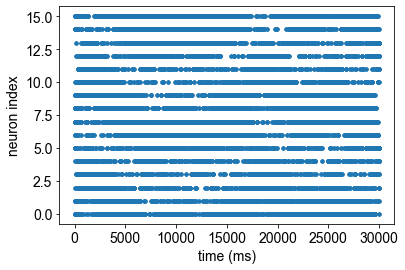

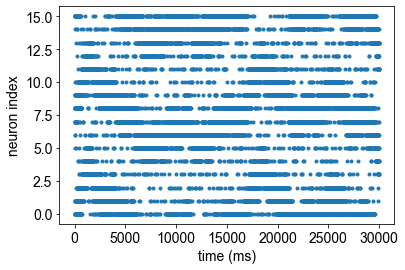

In [31]:
brian_plot(SPM_TL2)
plt.show()
brian_plot(SPM_TL2_IDEAL)

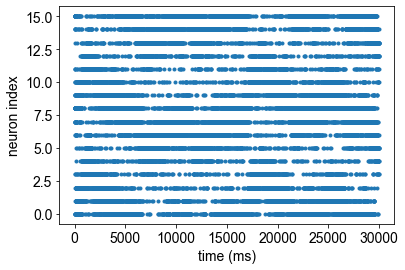

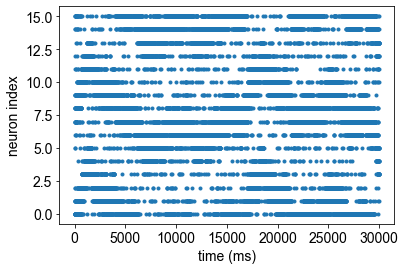

In [38]:
brian_plot(SPM_TL2)
plt.show()
brian_plot(SPM_TL2_IDEAL)

In [41]:
import nevergrad as ng

def square(x, y=12):
    return sum((x - .5)**2) + abs(y)

optimizer = ng.optimizers.OnePlusOne(instrumentation=2, budget=100)
# alternatively, you could use ng.optimizers.registry["OnePlusOne"]
# (registry is a dict containing all optimizer classes)
recommendation = optimizer.minimize(square)
print(recommendation)


Candidate(args=(array([0.5017027 , 0.49792428]),), kwargs={})
